# Prova Final - Machine Learning

**Nome do aluno**: <font color='red'>João Pedro Queiroz Viana</font>

Você deve submeter o trabalho via Blackboard. É de sua responsabilidade garantir que o arquivo correto foi enviado.

Se você precisou adicionar arquivos extras à essa prova, assegure-se de que você os está enviando também.

A prova é individual e com consulta - pode consultar suas anotações, a web, o que quiser, menos perguntar para outros ou para as AIs. Faça o seu trabalho de maneira ética!

ChatGPT para perguntas teóricas não é permitido. CoPilot para código é permitido.

## Instruções

Nesta prova vamos trabalhar com um dataset de informações acerca dos hábitos de pessoas que frequentam uma academia de ginástica.

As questões estão distribuidas ao longo do notebook, procure pela tag "**QUESTÕES**". Temos 5 questões ao todo, com vários sub-itens, somando 11 pontos! (Mas a prova satura em 10, ok?)

Boa prova!

***

# Parte 1: leitura de dados, separação treino-teste, EDA

Não temos questões nessa parte.

### Leitura dos dados

In [2]:
# Código para leitura dos dado, não esqueça de rodar!

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def read_data() -> tuple[pd.DataFrame, list[str], list[str], str]:
    """
    Lê o dataset de treino de membros da academia e retorna o DataFrame, 
    colunas categóricas, colunas numéricas e a coluna alvo.
    """
    cat_columns = [
        'Gender',
        'Workout_Type',
        'Experience_Level',
    ]
    num_columns = [
        'Weight (kg)',
        'Height (m)',
        'Max_BPM',
        'Avg_BPM',
        'Resting_BPM',
        'Session_Duration (hours)',
        'Fat_Percentage',
        'Water_Intake (liters)',
        'Workout_Frequency (days/week)',
        'BMI',
    ]
    target_column = 'Calories_Burned'
    dataset = pd.read_csv('gym_members_exercise_tracking.csv')
    return dataset, cat_columns, num_columns, target_column

In [3]:
dataset, cat_columns, num_columns, target_column = read_data()

### Separação treino-teste

In [4]:
from sklearn.model_selection import train_test_split

SEED = 42
test_size = 0.2

train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=test_size,
    random_state=SEED,
)

### EDA

In [5]:
for column in cat_columns:
    display(dataset[column].value_counts().sort_index())

Gender
Female    462
Male      511
Name: count, dtype: int64

Workout_Type
Cardio      255
HIIT        221
Strength    258
Yoga        239
Name: count, dtype: int64

Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64

In [6]:
display(dataset[num_columns] \
    .describe() \
    .transpose() \
    .style \
    .format({ \
        'mean': '{:.2f}', \
        'std': '{:.2f}', \
        'min': '{:.2f}', \
        '25%': '{:.2f}', \
        '50%': '{:.2f}', \
        '75%': '{:.2f}', \
        'max': '{:.2f}', \
    }) \
    .set_table_attributes('style="width: 50%;"'))


,count,mean,std,min,25%,50%,75%,max
Weight (kg),973.000000,73.85,21.21,40.00,58.10,70.00,86.00,129.90
Height (m),973.000000,1.72,0.13,1.50,1.62,1.71,1.80,2.00
Max_BPM,973.000000,179.88,11.53,160.00,170.00,180.00,190.00,199.00
Avg_BPM,973.000000,143.77,14.35,120.00,131.00,143.00,156.00,169.00
Resting_BPM,973.000000,62.22,7.33,50.00,56.00,62.00,68.00,74.00
Session_Duration (hours),973.000000,1.26,0.34,0.50,1.04,1.26,1.46,2.00
Fat_Percentage,973.000000,24.98,6.26,10.00,21.30,26.20,29.30,35.00
Water_Intake (liters),973.000000,2.63,0.60,1.50,2.20,2.60,3.10,3.70
Workout_Frequency (days/week),973.000000,3.32,0.91,2.00,3.00,3.00,4.00,5.00
BMI,973.000000,24.91,6.66,12.32,20.11,24.16,28.56,49.84


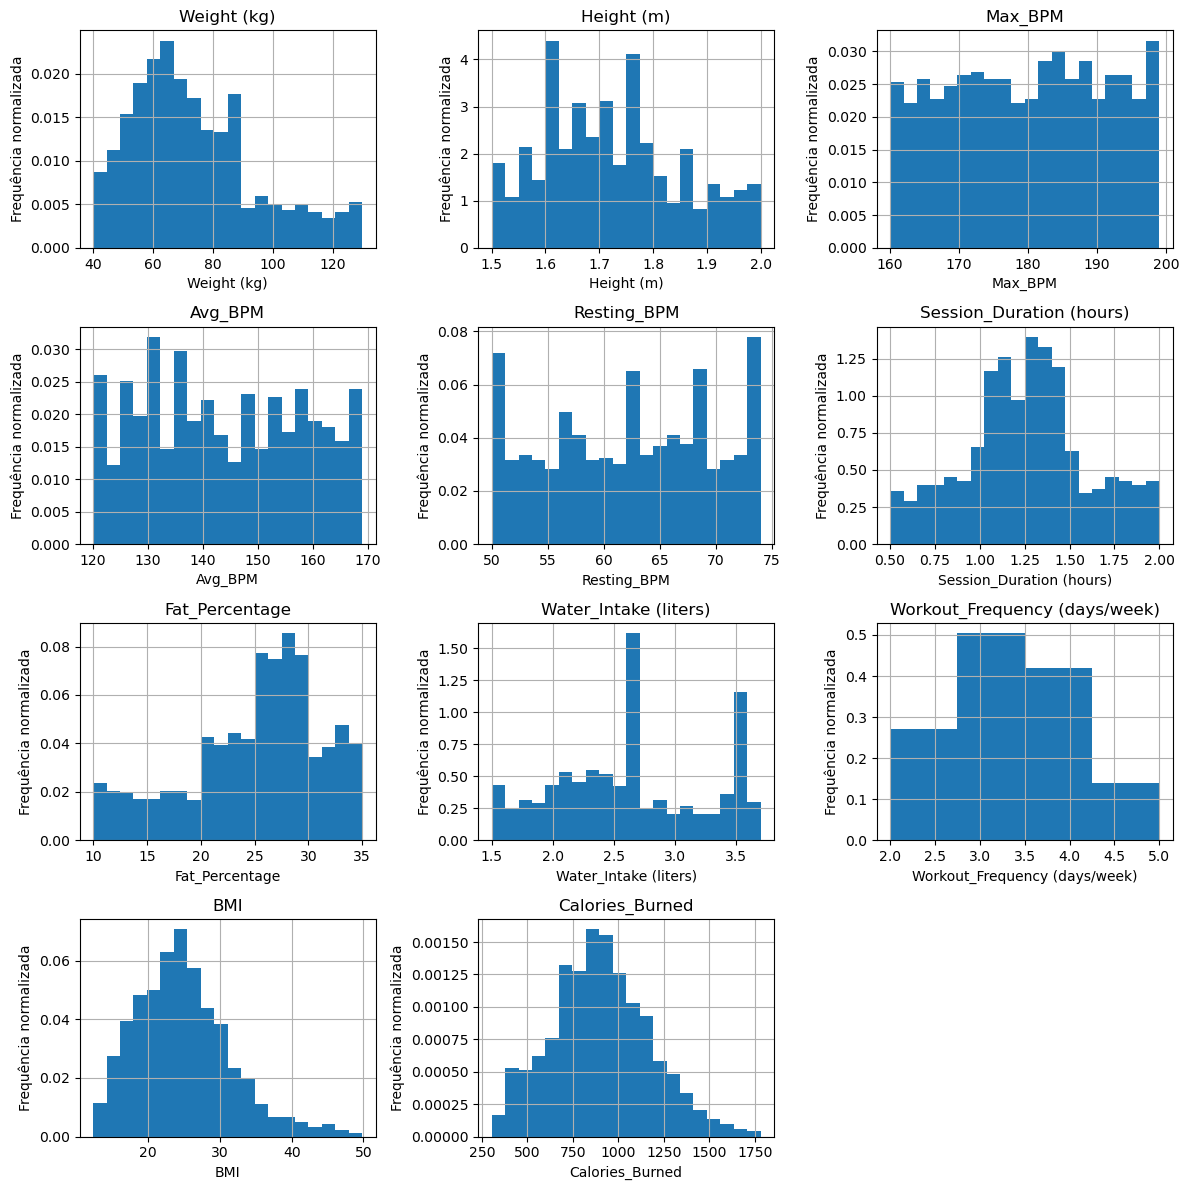

In [7]:
plt.figure(figsize=(12, 12))
for i, column in enumerate(num_columns + [target_column]):
    plt.subplot(4, 3, i + 1)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequência normalizada')
    plt.grid()
    plt.hist(
        dataset[column],
        bins=min(20, len(dataset[column].unique())),
        density=True,
    )
plt.tight_layout()
plt.show()


In [8]:
display(train_dataset[num_columns + [target_column]] \
    .corr() \
    .style \
    .background_gradient(cmap='coolwarm', axis=None) \
    .set_table_attributes('style="width: 50%;"') \
    .set_caption('Correlação entre variáveis numéricas'))

,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Weight (kg),1.000000,0.372351,0.049328,-0.011073,-0.013469,-0.011101,-0.234515,0.408174,0.005948,0.849798,0.095226
Height (m),0.372351,1.000000,-0.057417,-0.017122,-0.000547,-0.009226,-0.238102,0.391995,0.001349,-0.157753,0.087870
Max_BPM,0.049328,-0.057417,1.000000,-0.042396,0.027311,0.030093,-0.013544,0.030548,-0.021016,0.083389,0.019129
Avg_BPM,-0.011073,-0.017122,-0.042396,1.000000,0.070027,0.028216,-0.020048,-0.003184,-0.001472,-0.002203,0.344800
Resting_BPM,-0.013469,-0.000547,0.027311,0.070027,1.000000,0.023454,-0.031448,0.053768,0.020149,-0.013961,0.065211
Session_Duration (hours),-0.011101,-0.009226,0.030093,0.028216,0.023454,1.000000,-0.578470,0.254766,0.639245,-0.003247,0.909383
Fat_Percentage,-0.234515,-0.238102,-0.013544,-0.020048,-0.031448,-0.578470,1.000000,-0.586133,-0.536769,-0.125843,-0.603095
Water_Intake (liters),0.408174,0.391995,0.030548,-0.003184,0.053768,0.254766,-0.586133,1.000000,0.233791,0.229339,0.334206
Workout_Frequency (days/week),0.005948,0.001349,-0.021016,-0.001472,0.020149,0.639245,-0.536769,0.233791,1.000000,0.013200,0.578198
BMI,0.849798,-0.157753,0.083389,-0.002203,-0.013961,-0.003247,-0.125843,0.229339,0.013200,1.000000,0.058568


In [9]:
for column in cat_columns:
    display(train_dataset[num_columns + [target_column, column]] \
        .groupby(column) \
        .mean() \
        .sort_values(target_column) \
        .style \
        .format(precision=2) \
        .set_table_attributes('style="width: 50%;"') \
        .background_gradient(cmap='coolwarm', axis=0) \
        .set_caption(f'Média de {target_column} por {column}'))


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Gender,,,,,,,,,,,
Female,60.69,1.64,180.00,143.52,62.04,1.27,27.74,2.21,3.34,22.62,864.50
Male,84.92,1.80,179.74,143.52,62.35,1.25,22.65,3.02,3.33,26.61,938.78


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Workout_Type,,,,,,,,,,,
Cardio,74.52,1.72,180.02,143.53,61.59,1.23,25.48,2.64,3.24,25.22,888.52
Yoga,72.89,1.74,180.36,143.39,61.69,1.25,24.59,2.63,3.35,24.08,895.78
Strength,71.96,1.72,179.07,143.74,62.58,1.26,25.57,2.60,3.39,24.40,909.45
HIIT,75.09,1.72,180.12,143.38,62.98,1.29,24.33,2.70,3.36,25.26,923.98


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Experience_Level,,,,,,,,,,,
1,72.96,1.73,180.42,143.29,62.07,1.01,27.67,2.55,2.51,24.45,724.78
2,74.15,1.72,178.86,143.71,62.05,1.25,27.32,2.50,3.53,25.04,903.50
3,73.56,1.73,180.98,143.56,62.82,1.75,14.70,3.13,4.54,24.68,1263.68


In [10]:
for column_1 in cat_columns:
    for column_2 in cat_columns:
        if column_1 == column_2:
            continue
        display(pd.crosstab(
            train_dataset[column_1],
            train_dataset[column_2],
            normalize='columns',
        ).style \
            .background_gradient(cmap='coolwarm', axis=0) \
            .set_table_attributes('style="width: 50%;"') \
            .set_caption(f'Porcentagem de {column_1} por {column_2}'))


Workout_Type,Cardio,HIIT,Strength,Yoga
Gender,,,,
Female,0.483254,0.469274,0.478673,0.435754
Male,0.516746,0.530726,0.521327,0.564246


Experience_Level,1,2,3
Gender,,,
Female,0.479866,0.459215,0.463087
Male,0.520134,0.540785,0.536913


Gender,Female,Male
Workout_Type,,
Cardio,0.277473,0.260870
HIIT,0.230769,0.229469
Strength,0.277473,0.265700
Yoga,0.214286,0.243961


Experience_Level,1,2,3
Workout_Type,,,
Cardio,0.295302,0.253776,0.248322
HIIT,0.234899,0.208459,0.268456
Strength,0.261745,0.293051,0.241611
Yoga,0.208054,0.244713,0.241611


Gender,Female,Male
Experience_Level,,
1,0.392857,0.374396
2,0.417582,0.432367
3,0.189560,0.193237


Workout_Type,Cardio,HIIT,Strength,Yoga
Experience_Level,,,,
1,0.421053,0.391061,0.369668,0.346369
2,0.401914,0.385475,0.459716,0.452514
3,0.177033,0.223464,0.170616,0.201117


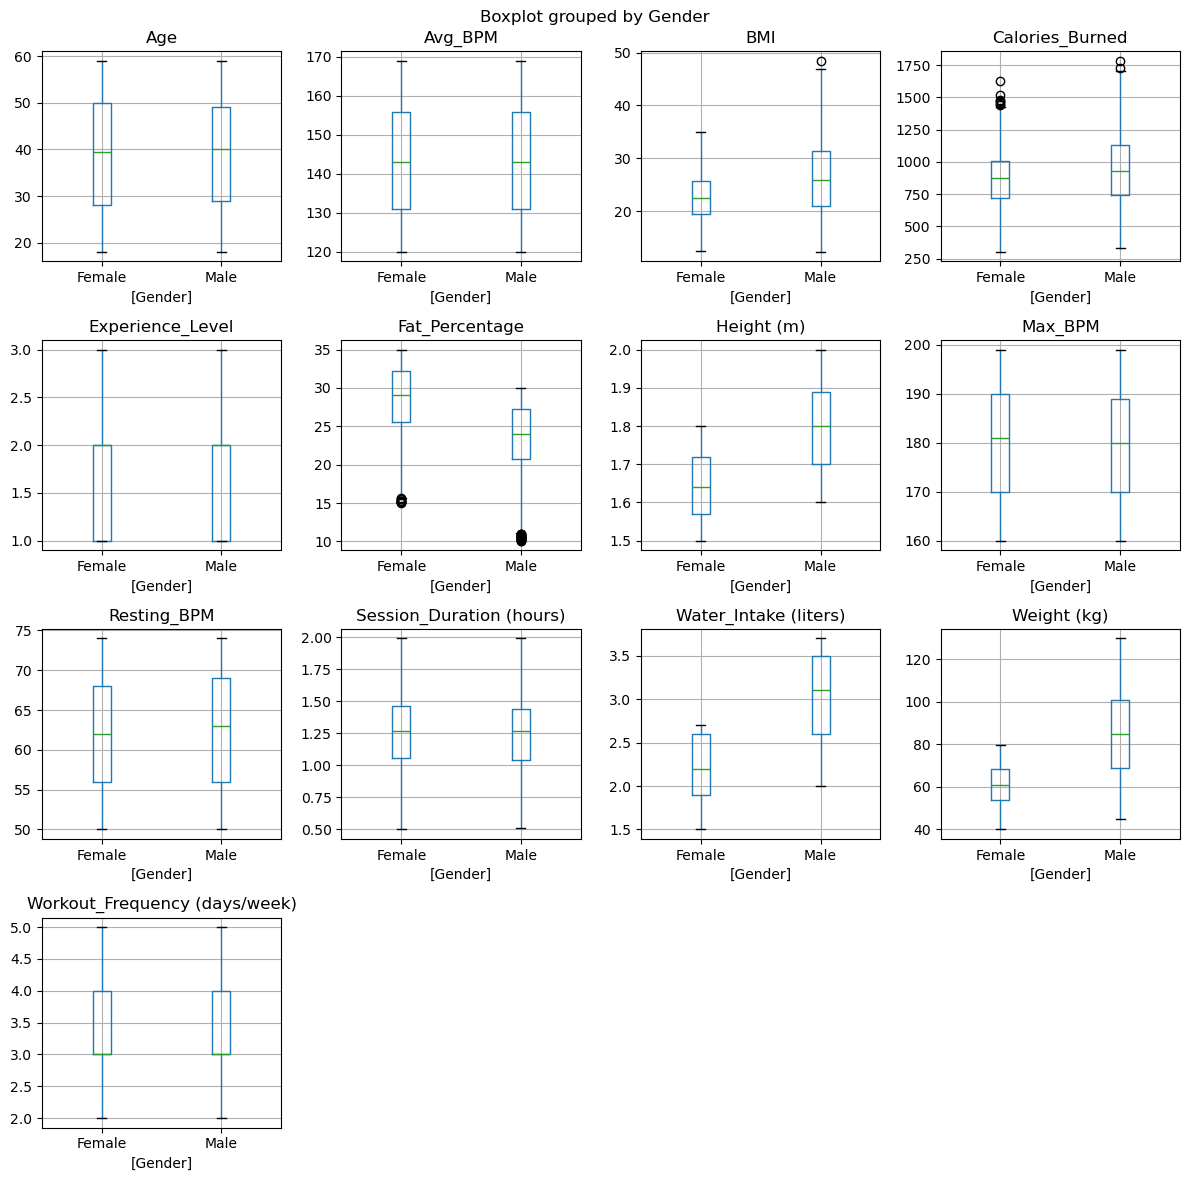

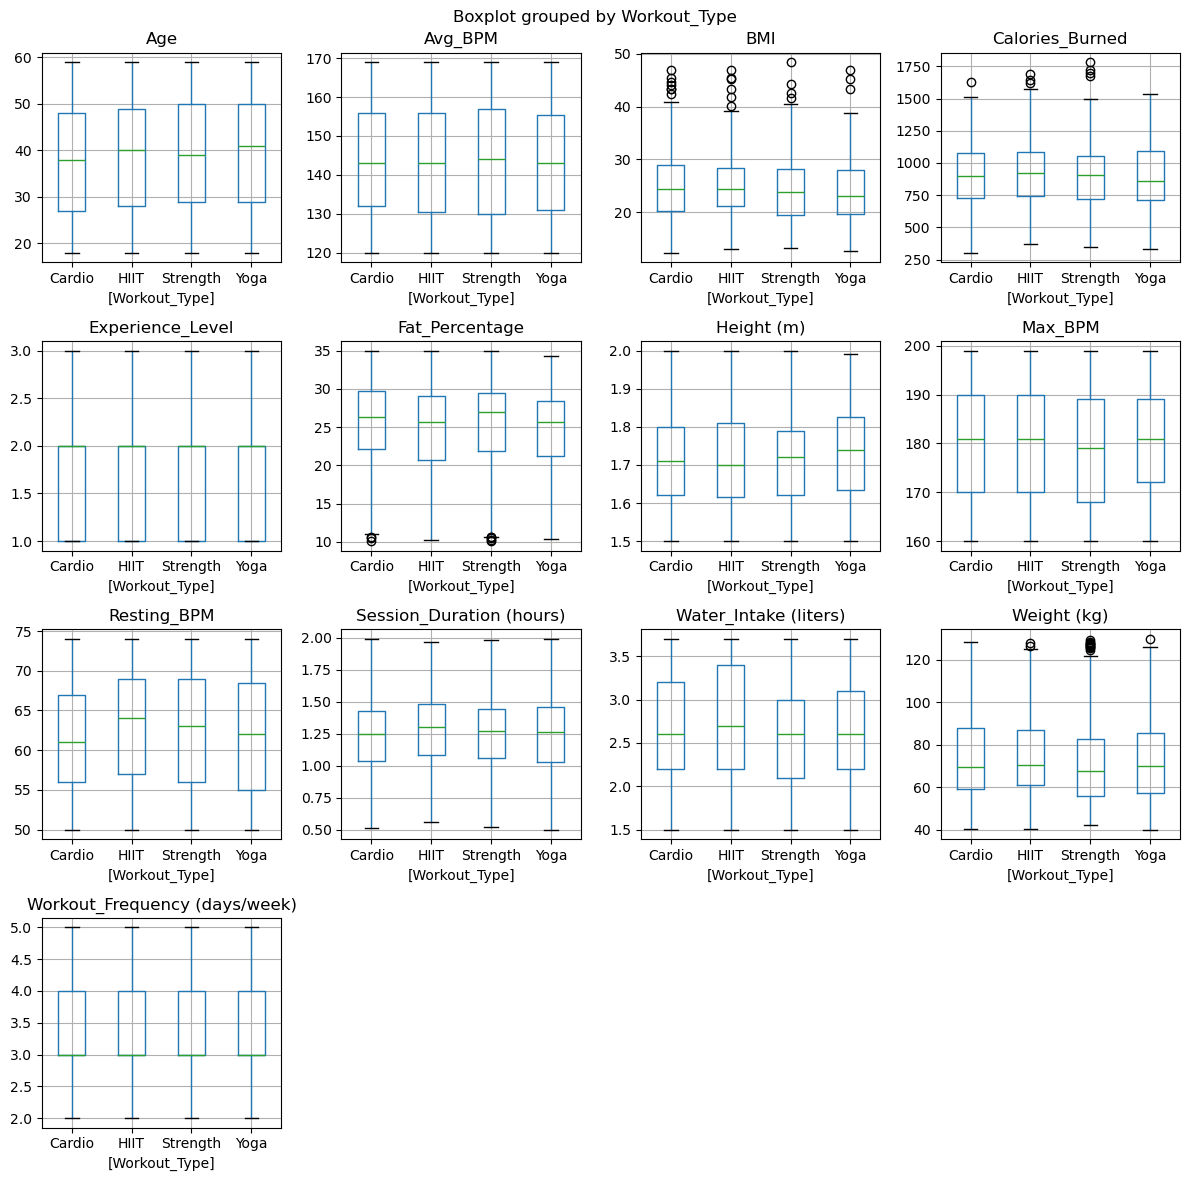

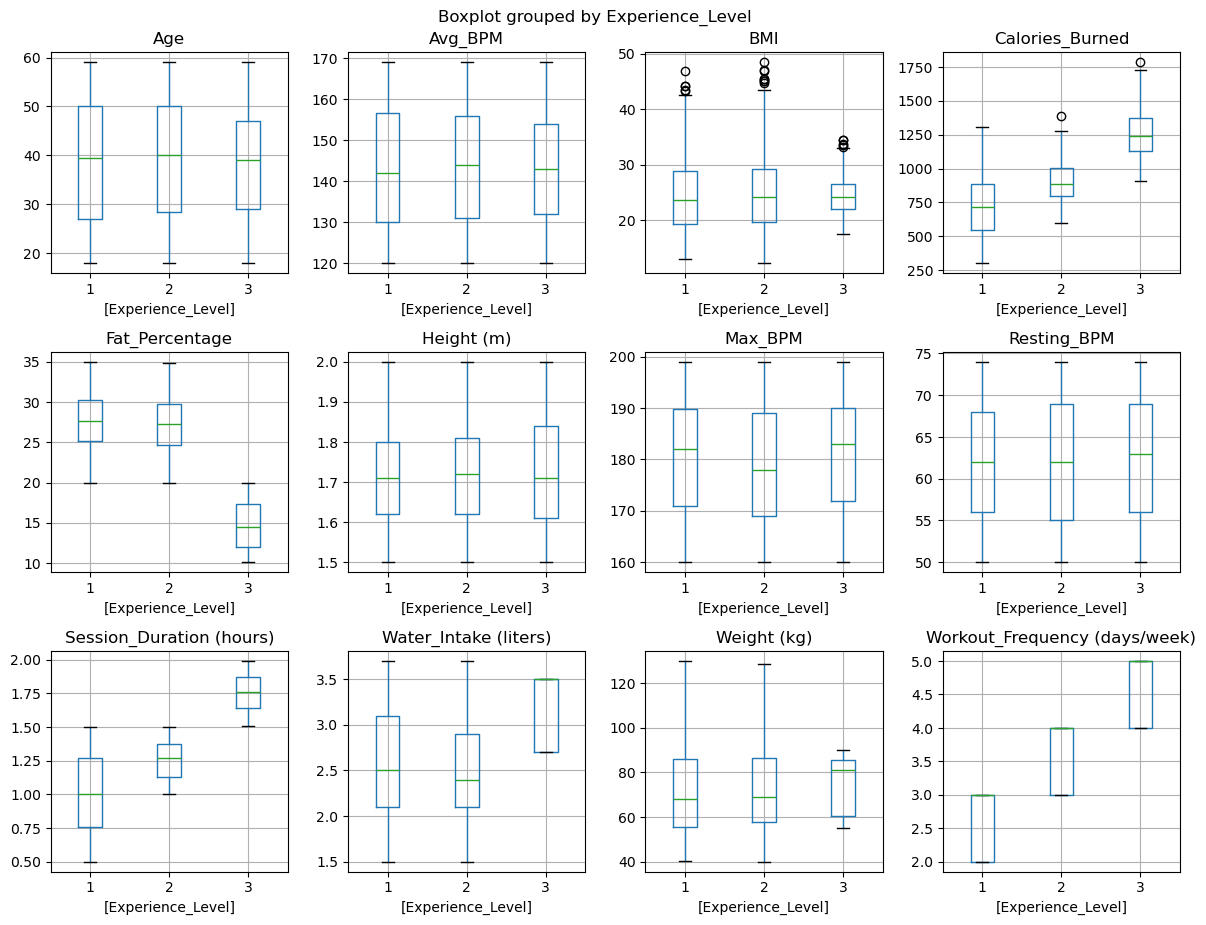

In [11]:
for cat_column in cat_columns:
    train_dataset.boxplot(by=cat_column, layout=(4, 4), sharex=False, sharey=False, figsize=(12, 12))
    plt.tight_layout()

# Parte 2: Aprendizado supervisionado

Nas questões a seguir vamos construir modelos de regressão para prever o gasto calórico em função das várias features do problema.

***

# **QUESTÕES**

***Questão 1*** (1.0 pt)

Construa um modelo do tipo LASSO para fazer seleção das features mais relevantes. Você deve:

- Fazer uma pipeline adequada para um modelo LASSO

- Testar vários valores de `alpha` até obter apenas entre 25% e 50% das features originais com pesos não-nulos.

In [12]:
X_train = train_dataset.drop(columns=[target_column])
y_train = train_dataset[target_column]
X_test = test_dataset.drop(columns=[target_column])
y_test = test_dataset[target_column]

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='passthrough',
)

model = Lasso(alpha=5.0)

lasso_model = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

param_grid_complex = {
    'model__alpha': [5.0, 10.0],
}

grid_search_lasso = GridSearchCV(
    lasso_model,
    param_grid_complex,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search_lasso.fit(X_train, y_train)
best_lasso_model = grid_search_lasso.best_estimator_
best_lasso_model_score = -grid_search_lasso.best_score_
best_lasso_model_params = grid_search_lasso.best_params_

print(f"Best Decision Tree Model Score: {best_lasso_model_score}")
print(f"Best Decision Tree Model Parameters: {best_lasso_model_params}")

non_zero_features = (best_lasso_model.named_steps['model'].coef_ != 0).sum()
total_features = len(best_lasso_model.named_steps['model'].coef_)
percentage_non_zero = (non_zero_features / total_features) * 100

print(f"Non-zero features: {non_zero_features}")
print(f"Total features: {total_features}")
print(f"Percentage of non-zero features: {percentage_non_zero:.2f}%")


if 25 <= percentage_non_zero <= 50:
    print("The model retained between 25% and 50% of the original features.")
else:
    print("The model did not retain between 25% and 50% of the original features.")

Best Decision Tree Model Score: 42.30499090066653
Best Decision Tree Model Parameters: {'model__alpha': 5.0}
Non-zero features: 8
Total features: 20
Percentage of non-zero features: 40.00%
The model retained between 25% and 50% of the original features.


***

# **QUESTÕES**

***Questão 2***

a) (1.0 pt) Construa um modelo do tipo "Decision Tree" e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

b) (1.0 pt) Construa um modelo do tipo `sklearn.svm.LinearSVR` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

c) (1.0 pt) Construa um modelo do tipo `sklearn.ensemble.RandomForestRegressor` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

d) (1.0 pt) Construa um modelo do tipo `sklearn.dummy.DummyRegressor`. Não vai fazer ajuste de hiperparâmetros aqui. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute a medida de desempenho no conjunto de treino com `cross_val_score`.

e) (0.5 pt) Para o melhor modelo dentre os itens anteriores, execute a etapa de certificação do modelo (treina no treino, testa no teste) e apresente o desempenho obtido.

f) (0.5 pt) Plote as predições versus os valores reais no conjunto de teste para ver se existe um bom ajuste.

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ord",     OrdinalEncoder())
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='passthrough',
)

model = DecisionTreeRegressor(max_depth=2, random_state=42)

decision_tree_model = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

param_grid_decisiontree = {
    'model__max_depth': [1, 2, 3, 4, 5],
    'model__min_samples_split': [2, 3, 4, 5],
    'model__min_samples_leaf': [1, 2, 3, 4],
}

grid_search_deciisontree = GridSearchCV(
    decision_tree_model,
    param_grid_decisiontree,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search_deciisontree.fit(X_train, y_train)
best_decision_tree_model = grid_search_deciisontree.best_estimator_
best_decision_tree_model_score = -grid_search_deciisontree.best_score_
best_decision_tree_model_params = grid_search_deciisontree.best_params_

print(f"Best Decision Tree Model Score: {best_decision_tree_model_score}")
print(f"Best Decision Tree Model Parameters: {best_decision_tree_model_params}")

Best Decision Tree Model Score: 83.69134911878047
Best Decision Tree Model Parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2}


In [15]:
from sklearn.svm import LinearSVR

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ord",     OrdinalEncoder())
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='passthrough',
)

model = LinearSVR(epsilon=1.5)

linearsvr_model = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

param_grid_linearsvr = {
    'model__C': [0.1, 0.5, 1.0, 5.0, 10.0],
    'model__epsilon': [0.1, 0.5, 1.0, 1.5],
    'model__max_iter': [1000, 2000, 3000],
    'model__tol': [1e-4, 1e-3, 1e-2],
}

grid_search_linearsvr= GridSearchCV(
    linearsvr_model,
    param_grid_linearsvr,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search_linearsvr.fit(X_train, y_train)
best_linearsvr_model = grid_search_linearsvr.best_estimator_
best_linearsvr_model_score = -grid_search_linearsvr.best_score_
best_linearsvr_model_params = grid_search_linearsvr.best_params_

print(f"Best Linear SVR Model Score: {best_linearsvr_model_score}")
print(f"Best Linear SVR Model Parameters: {best_linearsvr_model_params}")

Best Linear SVR Model Score: 76.85132535299114
Best Linear SVR Model Parameters: {'model__C': 10.0, 'model__epsilon': 1.5, 'model__max_iter': 1000, 'model__tol': 0.01}


In [16]:
from sklearn.ensemble import RandomForestRegressor

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='passthrough',
)

model = RandomForestRegressor(random_state=42)

randomforest_model = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

param_grid_randomforest = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

grid_search_randomforest= GridSearchCV(
    randomforest_model,
    param_grid_randomforest,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search_randomforest.fit(X_train, y_train)
best_randomforest_model = grid_search_randomforest.best_estimator_
best_randomforest_model_score = -grid_search_randomforest.best_score_
best_randomforest_model_params = grid_search_randomforest.best_params_

print(f"Best Rabdin Firest Regressor Model Score: {best_randomforest_model_score}")
print(f"Best Rabdin Firest Regressor Model Parameters: {best_randomforest_model_params}")

Best Rabdin Firest Regressor Model Score: 50.05188693811794
Best Rabdin Firest Regressor Model Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [17]:
from sklearn.dummy          import DummyRegressor
from sklearn.model_selection import cross_val_score

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ord",     OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='passthrough',
)

model = DummyRegressor()

dummyregressor_model = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model),
])

cross_val_dummyregressor = cross_val_score(
    dummyregressor_model,
    X_train,
    y_train,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)


dummyregressor_model.fit(X_train, y_train)
dummyregressor_model_score = -cross_val_dummyregressor.mean()
dummyregressor_model_params = None

print(f"Dummy Regressor Model Score: {dummyregressor_model_score}")
print(f"Dummy Regressor Model Parameters: {dummyregressor_model_params}")

Dummy Regressor Model Score: 267.91754514677814
Dummy Regressor Model Parameters: None


In [18]:
from sklearn.metrics import mean_squared_error

best_randomforest_model.fit(X_train, y_train)

test_predictions = best_randomforest_model.predict(X_test)

test_rmse = mean_squared_error(y_test, test_predictions)

print(f"Desempenho do melhor modelo no conjunto de teste (RMSE): {test_rmse}")

Desempenho do melhor modelo no conjunto de teste (RMSE): 2354.32992318341


***

# **QUESTÕES**

***Questão 3*** Teoria

a) (0.5 pt) Explique porque a técnica de Support Vector Machines tende ao overfitting se o parâmetro de penalidade $C$ é alto, e porque tende ao underfitting se ele é baixo.

b) (0.5 pt) Explique porque em geral o *bagging* permite treinamento em paralelo e o *boosting* (qualquer um: AdaBoost, Gradient Boosting, etc) não permite

c) (0.5 pt) Explique porque uma árvore de decisão não requer normalização dos dados

Respostas:

a) Pois, quando o paramétro de penalidada $C$ é alto, eke perimitirá que poucas features fiquem dentro da área da "avenida" que o modelo constrói, adaptando-se muito ao treino do dataset, fazendo predições melhores no treino e predições ruins no teste. Enquanto que, quando o paramétro de penalidada $C$ é baixo, ele premite que muitas features fiquem dentro da área da "avenida" que o modelo constrói, fazendo com que o modelo não se adapte direito ao features da dateset, provocando predições ruins tanto no treino como no teste.

b) O metódo bagging permite treinos em paralelo já que ele treina algorítmos diferentes ou o mesmo tipo de algorítmo em diferentes subpartes randomizadas de um dataset de treino ao mesme tempo, enquanto o metódo boosting basea-se na ideia de treinar os preditores/algorítmos de forma sequencial.

c) Pois os algorítmos de árvore de decisão basean-se em características diferentes de cada feature do dataset para fazer a classificação, a normalização dos dados dificultaria essa decisão já que faria com que as features do dataset não tenham mais características distintas que seriam usadas na montagem da árvore dos modelos de árvore de decisão e sua respectiva classificação.

***

# Parte 3: Aprendizado não supervisionado

Nesta parte não vamos identificar nenhum *target*, nosso foco é na análise não-supervisionada do dataset completo.

***

# **QUESTÕES**

***Questão 4***

a) (0.5 pt) Construa uma pipeline que transforma o dataset completo em um dataset que apresenta valores apropriados para executar uma PCA. Por exemplo: as variáveis categóricas vão precisar de one-hot encoding. O que mais é necessário? Você deve mostrar seu conhecimento.

b) (0.5 pt) Vamos aplicar a PCA no dado transformado, com apenas 2 componentes. O código abaixo faz esse serviço para um dataset transformado `X_transf`:

```Python
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transf)
```

Faça um scatter plot das componentes principais (as colunas de `X_pca`)

c) (1.0 pt) Execute uma clusterização com KMeans em `X_pca` para várias escolhas de k: 2, 3, 4, 5 e 6. Para cada valor de k visualize o scatter plot de `X_pca` colorido pelos *labels* de cluster. Visualmente, qual a melhor escolha?

Dica: 

```Python
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
```

d) (0.5 pt) Como você usaria a informação do clustering para identificar o perfil de clientes da academia em cada cluster? Não precisa implementar, é só uma pergunta qualitativa, precisa explicar.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),
])


categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])


preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_columns),
        ('cat', categorical_pipeline, cat_columns),
    ],
    remainder='drop',
)

X_transf = preprocessing_pipeline.fit_transform(dataset)

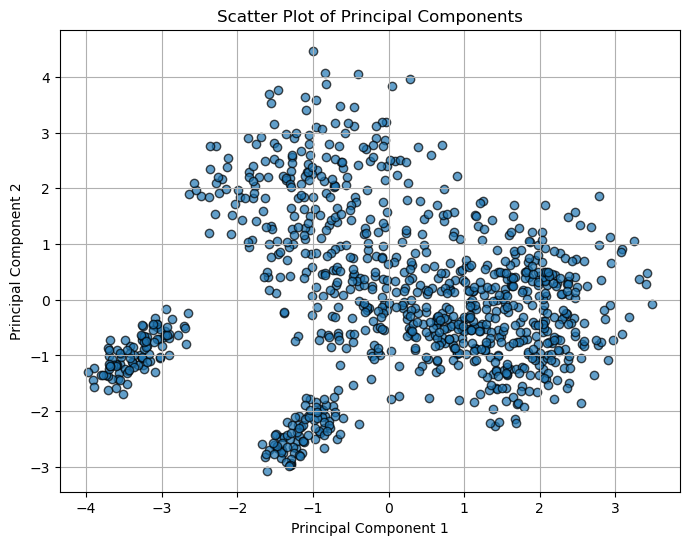

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transf)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

c:\Users\jpqv0\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\jpqv0\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\jpqv0\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\jpqv0\anaconda3\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known

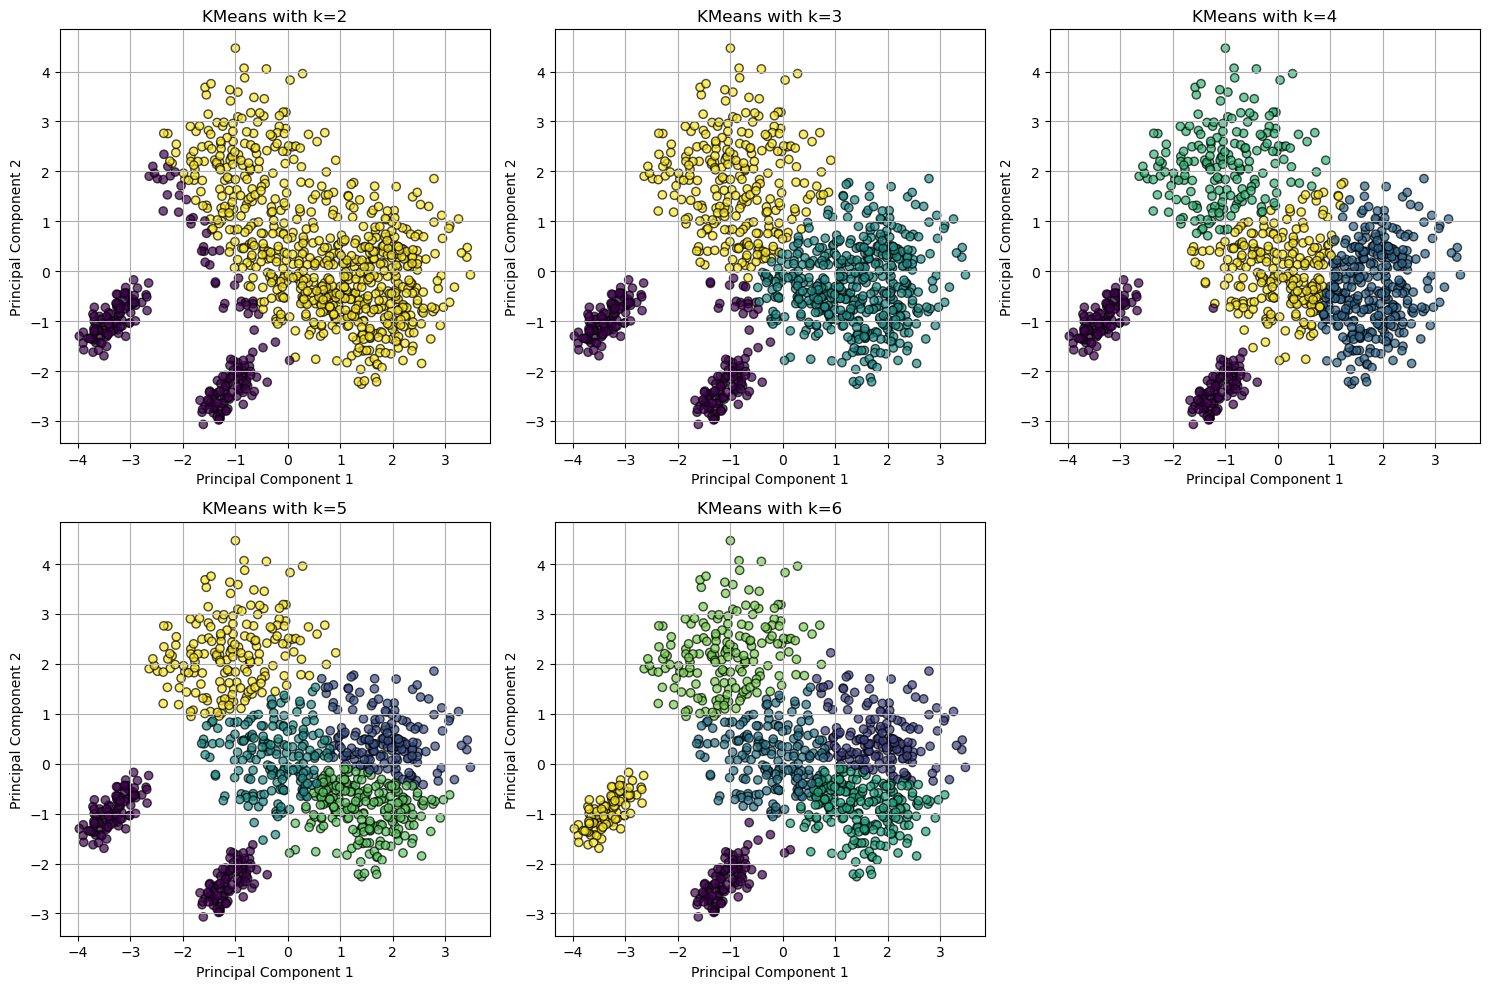

In [21]:
from sklearn.cluster import KMeans

k_values = [2, 3, 4, 5, 6]

plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    
    plt.subplot(2, 3, i)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7, edgecolors='k')
    plt.title(f'KMeans with k={k}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()

plt.tight_layout()
plt.show()

Resposta do item d:

Como os clusters fazem uma separação de grupos, o ideal seria observar as feature presente em cada cluster e classificar o grupo formado pelo cluster. Com essaas classificações feitas e sabendo o prefil dos clientes presentes em cada cluster, agora seria observar os dados de cada clientes e compará-los com os dados presentes em cada cluster e definir em qual grupo do cluster o cliente mais se encaixa. Assim, ao descobrir o cluster em que o cliente mais se encaia, é possível definir o perfil do cliente.

***Questão bonus*** (1.0 pt)

As redes neurais já deixaram de ser primariamente inspiradas pela biologia já faz muito tempo. Hoje em dia as redes neurais são apenas funções bem flexíveis do tipo $y = f(x, \theta)$, e são aplicadas nos mais diversos contextos. Considere um par de redes neurais $f$ e $g$ para fazer o seguinte:

$$
z = f(x, \theta_f)
\hat{x} = g(z, \theta_g)
$$

Ou seja, estamos prevendo $x$ com ele mesmo! Imagine, contudo, que o número de features em $z$ é bem menor que aquele em $x$ - um gargalo de informação. Este modelo é chamado *autoencoder*, e realiza redução de dimensionalidade.

Qual a diferença entre um *autoencoder* com redes neurais e uma PCA?


Resposta: 

Os autoencoders baseam-se na ideia de que eles fazem um simples aprendizado para copiar os seus inputs para os seus outputs, sendo possível treinar a rede neural para recuperar os inputs originais, enquanto a PCA usa a ideia de múltiplas projeções para tranformar os inputs e, nessa transformação, ocorre perda de informação, o que impossibilita a recuperação dos inputs originais.

Boa prova!